# Statistical comparison of hyperparameter searched models with Bayesian Analysis

This tutorial is adopted from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#sphx-glr-auto-examples-model-selection-plot-grid-search-stats-py

This short tutorial showcases on comparing statistical models using Bayesian analysis. Relying solely on arbitrary metrics, such as accuracy, probability of error or ROC AUC, does not give enough information on which model is better on a given data set or problem. The reason being that the models are applied and tested on the **same dataset**.

This tutorial shows on applying Grid, Randomized and Adaptive search on the Iris data set, using Support Vector machine and Logistic regression. After searching for a range of different hyperparameters, a Bayesian analysis is applied, afterwhich we examine the parameters of the models using cooperative game theory.

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from scipy.stats import t
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
from itertools import combinations
from math import factorial

from skopt import BayesSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import shap
from alibi.explainers import KernelShap


import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
def get_hyperparameter_scores( search ):
    results_df = pd.DataFrame(search.cv_results_)
    results_df = results_df.sort_values(by=["rank_test_score"])
    results_df = results_df.set_index(
        results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
    ).rename_axis("kernel")
    
    return results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

In [3]:
iris = load_iris()
X, y = load_iris( return_X_y = True )

scaler   = StandardScaler().fit( X )
X_normed = scaler.transform( X )
Xtrain, Xtest, ytrain, ytest = train_test_split( X_normed, y, train_size = 0.75, test_size = .25, random_state = 0 )

cv = RepeatedStratifiedKFold( n_splits = 10, n_repeats = 10, random_state = 0 ) # A 10x 10-fold cross-validation

### Setting up models

An usual approach in finding hyperparameters for a model on a given dataset is to use sampling methods like cross-validation. The scores obtained from these sampling methods are not independent because these models are searched and evaluated on the same dataset, and the end results depends on the particular fold.

Here a statistical approach of Benavoli, A. et al. "Time for a change: a tutorial for comparing multiple classifiers through Bayesian analysis". The Journal of Machine Learning Research, 18(1), 2017, will be illustrated in comparing statistical models.

First we setup our models.

In [4]:
svc_as = BayesSearchCV(
                        SVC(),
                        {
                            'C': (1e-6, 1e+6, 'log-uniform'),
                            'gamma': (1e-6, 1e+1, 'log-uniform'),
                            'degree': (1, 8),  # integer valued parameter
                            'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
                        },
                        n_iter=10,
                        cv = cv
                     )

svc_as.fit( Xtrain, ytrain )

print("params    : %s" % svc_as.best_params_)
print("val. score: %s" % svc_as.best_score_)
print("test score: %s" % svc_as.score(Xtest, ytest))

params    : OrderedDict([('C', 4.027462393160763), ('degree', 6), ('gamma', 0.0004804379529945286), ('kernel', 'linear')])
val. score: 0.9634848484848484
test score: 0.9736842105263158


In [5]:
svc_rs = RandomizedSearchCV( 
                            SVC(), 
                            {
                              'C'     : stats.loguniform(1e-6, 1e+6),
                              'gamma' : stats.loguniform(1e-6, 1e+1),
                              'degree': stats.randint(1, 8),         
                              'kernel': ['linear', 'poly', 'rbf'], 
                            }, 
                            n_iter = 10, 
                            cv = cv, 
                            n_jobs = 6 )
svc_rs.fit( Xtrain, ytrain )

print("params    : %s" % svc_rs.best_params_)
print("val. score: %s" % svc_rs.best_score_)
print("test score: %s" % svc_rs.score(Xtest, ytest))

params    : {'C': 0.7668154811273687, 'degree': 6, 'gamma': 0.0017982255363211386, 'kernel': 'linear'}
val. score: 0.9572727272727272
test score: 0.9736842105263158


In [6]:
svc_gs = GridSearchCV( 
                       SVC(), 
                       {
                         'C'     : np.power(10, np.arange(-4, 1, dtype=float)),
                         'gamma' : np.power(10, np.arange(-4, 1, dtype=float)),
                         'degree': np.arange(1, 9, dtype = int ),         
                         'kernel': ['linear', 'poly', 'rbf'], 
                       }, 
                       cv = cv, 
                       n_jobs = 6 )

svc_gs.fit( Xtrain, ytrain )

print("params    : %s" % svc_gs.best_params_)
print("val. score: %s" % svc_gs.best_score_)
print("test score: %s" % svc_gs.score(Xtest, ytest))

params    : {'C': 0.1, 'degree': 1, 'gamma': 0.0001, 'kernel': 'linear'}
val. score: 0.9545454545454544
test score: 0.9736842105263158


In [7]:
lgr_as = BayesSearchCV(
                        LogisticRegression(),
                        {
                            'C': (1e-6, 1e+6, 'log-uniform'),
                            'tol': (1e-6, 1e+1, 'log-uniform'),
                            'max_iter': (100, 400),  
                            'solver': ['sag', 'saga', 'newton-cg'],
                        },
                        n_iter=10,
                        cv = cv
                     )

lgr_as.fit( Xtrain, ytrain )

print("params    : %s" % lgr_as.best_params_)
print("val. score: %s" % lgr_as.best_score_)
print("test score: %s" % lgr_as.score(Xtest, ytest))

params    : OrderedDict([('C', 550976.0395786805), ('max_iter', 268), ('solver', 'saga'), ('tol', 0.0004225554565421113)])
val. score: 0.9688636363636363
test score: 0.9736842105263158


In [ ]:
lgr_rs = RandomizedSearchCV(
                        LogisticRegression(),
                        {
                            'C':   stats.loguniform(1e-6, 1e+6),
                            'tol': stats.loguniform(1e-6, 1e+6),
                            'max_iter': stats.randint(100, 400),  # integer valued parameter
                            'solver': ['sag', 'saga', 'newton-cg'],  # categorical parameter
                        },
                        n_iter=10,
                        cv = cv
                     )

lgr_rs.fit(Xtrain, ytrain)

print("params    : %s" % lgr_rs.best_params_)
print("val. score: %s" % lgr_rs.best_score_)
print("test score: %s" % lgr_rs.score(Xtest, ytest))

In [9]:
lgr_gs = GridSearchCV(
                        LogisticRegression(),
                        {
                            'C'       : np.power(10, np.arange(-4, 1, dtype=float)),
                            'tol'     : np.power(10, np.arange(-4, 1, dtype=float)),
                            'max_iter': np.arange(100, 450, 50, dtype = int ),  # integer valued parameter
                            'solver': ['sag', 'saga', 'newton-cg'],  # categorical parameter
                        },
                        cv = cv
                     )

lgr_gs.fit(Xtrain, ytrain)

print("params    : %s" % lgr_gs.best_params_)
print("val. score: %s" % lgr_gs.best_score_)
print("test score: %s" % lgr_gs.score(Xtest, ytest))

params    : {'C': 1.0, 'max_iter': 300, 'solver': 'sag', 'tol': 0.1}
val. score: 0.9570454545454544
test score: 0.9736842105263158


In [10]:
svc_gs_df = get_hyperparameter_scores( svc_gs )
svc_rs_df = get_hyperparameter_scores( svc_rs )
svc_as_df = get_hyperparameter_scores( svc_as )

svc_scores = pd.concat( [ svc_gs_df.head( 1 ), svc_rs_df.head( 1 ), svc_as_df.head( 1 ) ] )

svc_scores.rename( index = { svc_scores.index[ 0 ]: 'SVC-GS', 
                             svc_scores.index[ 1 ]: 'SVC-RS',
                             svc_scores.index[ 2 ]: 'SVC-AS'
                           } 
                  ,inplace = True 
                 )

svc_scores.head()

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
SVC-GS,"{'C': 0.1, 'degree': 6, 'gamma': 0.1, 'kernel'...",1,0.954545,0.054123
SVC-RS,"{'C': 0.7668154811273687, 'degree': 6, 'gamma'...",1,0.957273,0.054054
SVC-AS,"{'C': 4.027462393160763, 'degree': 6, 'gamma':...",1,0.963485,0.052183


In [11]:
lgr_as_df  = get_hyperparameter_scores( lgr_as )
lgr_rs_df  = get_hyperparameter_scores( lgr_rs )
lgr_gs_df  = get_hyperparameter_scores( lgr_gs )

lgr_scores = pd.concat( [ lgr_gs_df.head( 1 ), lgr_rs_df.head( 1 ), lgr_as_df.head( 1 ) ] )

lgr_scores.rename( index = { lgr_scores.index[ 0 ]: 'LGR-GS', 
                             lgr_scores.index[ 1 ]: 'LGR-RS',
                             lgr_scores.index[ 2 ]: 'LGR-AS'
                           } 
                 , inplace = True )
lgr_scores.head()

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
LGR-GS,"{'C': 1.0, 'max_iter': 300, 'solver': 'sag', '...",1,0.957045,0.054483
LGR-RS,"{'C': 1.9560076215347661, 'max_iter': 139, 'so...",1,0.953561,0.057142
LGR-AS,"{'C': 550976.0395786805, 'max_iter': 268, 'sol...",1,0.968864,0.049387


In [12]:
result_scores = pd.concat( [ svc_scores, lgr_scores ] )
result_scores.head( 10 )

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
SVC-GS,"{'C': 0.1, 'degree': 6, 'gamma': 0.1, 'kernel'...",1,0.954545,0.054123
SVC-RS,"{'C': 0.7668154811273687, 'degree': 6, 'gamma'...",1,0.957273,0.054054
SVC-AS,"{'C': 4.027462393160763, 'degree': 6, 'gamma':...",1,0.963485,0.052183
LGR-GS,"{'C': 1.0, 'max_iter': 300, 'solver': 'sag', '...",1,0.957045,0.054483
LGR-RS,"{'C': 1.9560076215347661, 'max_iter': 139, 'so...",1,0.953561,0.057142
LGR-AS,"{'C': 550976.0395786805, 'max_iter': 268, 'sol...",1,0.968864,0.049387


### Bayes analysis on models

After we have found the set of hyperparameters, which search strategy provided the best model?

Here all models will be evaluated pairwise using Baysian estimation, giving a distribution of mean differences between models. A Normal-Gamma distribution, conjugate to a normal likelihod, is used as a prior for the Bayesian estimation. This allows expressing the resulting posterior distribution as a Gaussian. The variance is removed by marginalizing the Gaussian posterior, which allows us to express the posterior of the mean parameter as a Student's t-distribution.

To evaluate do models perform equally, worse or better, a *region of practical equivalence* is defined. The region will indicate how well the models compare in performance. As an example, if we set the region to 1\%, then the compared models will be considered equivalent if their performance differ less than 1\%. 

We will use the 1\% region threshold in the model comparison.

In [13]:
a             = 0.01
rope_interval = [-a, a]

n_train = len(list(cv.split(Xtrain, ytrain))[0][0])
n_test  = len(list(cv.split(Xtrain, ytrain))[0][1])

In [14]:
def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std

In [15]:
model_scores = result_scores.copy()
model_scores = model_scores[ [ 'mean_test_score', 'std_test_score' ] ]
model_scores.head( 10 )

,mean_test_score,std_test_score
kernel,,
SVC-GS,0.954545,0.054123
SVC-RS,0.957273,0.054054
SVC-AS,0.963485,0.052183
LGR-GS,0.957045,0.054483
LGR-RS,0.953561,0.057142
LGR-AS,0.968864,0.049387


In [16]:
pairwise_bayesian = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    t_post = t(
        differences.shape[ 0 ] - 1, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
    )
    worse_prob = t_post.cdf(rope_interval[0])
    better_prob = 1 - t_post.cdf(rope_interval[1])
    rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

    pairwise_bayesian.append([model_scores.index[model_i], model_scores.index[model_k],
                              worse_prob, better_prob, rope_prob])

pairwise_bayesian_df = pd.DataFrame(
    pairwise_bayesian, columns=[ "model_1", "model_2", "worse_prob", "better_prob", "rope_prob"]
).round(3)

In [17]:
pairwise_bayesian_df.sort_values( by = [ 'better_prob' ], ascending = False )

,model_1,model_2,worse_prob,better_prob,rope_prob
10,SVC-AS,LGR-RS,0.187,0.265,0.548
14,LGR-RS,LGR-AS,0.356,0.239,0.405
4,SVC-GS,LGR-AS,0.355,0.198,0.447
13,LGR-GS,LGR-AS,0.305,0.195,0.500
8,SVC-RS,LGR-AS,0.301,0.188,0.511
9,SVC-AS,LGR-GS,0.122,0.175,0.703
1,SVC-GS,SVC-AS,0.239,0.134,0.627
11,SVC-AS,LGR-AS,0.153,0.122,0.725
7,SVC-RS,LGR-RS,0.112,0.119,0.769
5,SVC-RS,SVC-AS,0.166,0.113,0.721


### Parameter estimation

The above table is sorted in decreasing order, in terms of better performance in probability. In this dataset, with the set hyperparameters and their ranges, the Support Vector Machine model obtained with adaptive search performed best in probability.

However, just observing the classification result is not enough for selecting a suitable statistical model for most problems. This is because most problems you cannot know or compute what is a statistically optimal result. This is the case, for example, in epidemiological studies or medical studies, where there is a large variability in observations. Another thing to consider is the consequences of the classification: metrics used in supervised learning tells us the probability of an estimator *identifying* an unseen input, and not the cost of making a wrong identification. 

Additionally to obtaining a "good enough" classification result, one should also check the parameter values learned by the estimators ( that is, the ranges of the random variables used in doing the classification ). Here we show an exmaple of using cooperative game theory in how features in the dataset affect in classifying the labels.

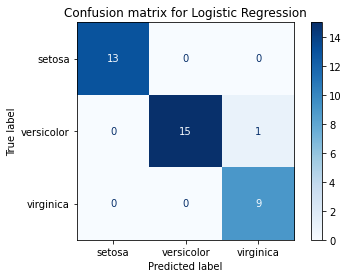

In [24]:
lgr = LogisticRegression( C        = lgr_rs.best_params_[ 'C' ],
                          max_iter = lgr_rs.best_params_[ 'max_iter' ],
                          solver   = lgr_rs.best_params_[ 'solver' ],
                          tol      = lgr_rs.best_params_[ 'tol' ]
                        ) 
lgr.fit( Xtrain, ytrain )

y_pred = lgr.predict( Xtest )

cm = confusion_matrix( ytest, y_pred )
title = 'Confusion matrix for Logistic Regression'
disp = plot_confusion_matrix(lgr,
                             Xtest,
                             ytest,
                             display_labels = iris.target_names,
                             cmap           = plt.cm.Blues,
                             normalize      = None,
                            )
disp.ax_.set_title( title );

Using 112 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/38 [00:00<?, ?it/s]

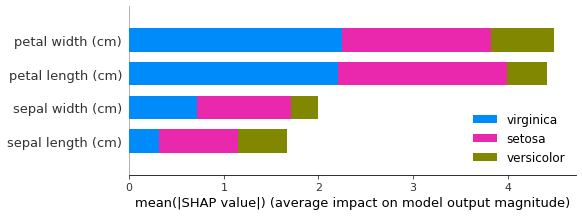

In [25]:
pred_fn = lgr.decision_function
np.random.seed( 0 )
lgr_exp = KernelShap( pred_fn )
lgr_exp.fit( Xtrain )
lgr_shap_vals = lgr_exp.explain( Xtest, l1_reg = False )

shap.summary_plot( lgr_shap_vals.shap_values, Xtest, iris.feature_names, class_names = iris.target_names )

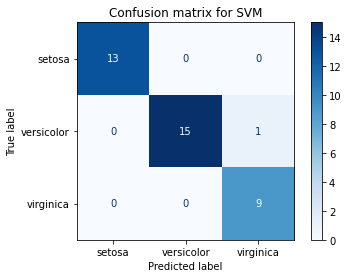

In [22]:
svc = SVC( C      = svc_as.best_params_[ 'C' ],
           degree = svc_as.best_params_[ 'degree' ],
           gamma  = svc_as.best_params_[ 'gamma' ],
           kernel = svc_as.best_params_[ 'kernel' ]
         )

svc.fit( Xtrain, ytrain )

y_pred = svc.predict( Xtest )

cm = confusion_matrix( ytest, y_pred )
title = 'Confusion matrix for SVM'
disp = plot_confusion_matrix(svc,
                             Xtest,
                             ytest,
                             display_labels = iris.target_names,
                             cmap           = plt.cm.Blues,
                             normalize      = None,
                            )
disp.ax_.set_title( title );

Using 112 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/38 [00:00<?, ?it/s]

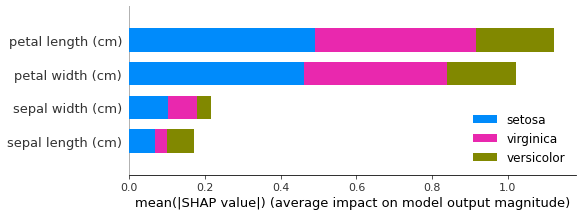

In [23]:
pred_fn = svc.decision_function
np.random.seed( 0 )
svc_exp = KernelShap( pred_fn )
svc_exp.fit( Xtrain )
svc_shap_vals = svc_exp.explain( Xtest, l1_reg = False )

shap.summary_plot( svc_shap_vals.shap_values, Xtest, iris.feature_names, class_names = iris.target_names )

## Summary

Model selection should always be estimated statistically, and additionally inspect the learned parameters, before selecting the final model for your problem. Also expert knowledge of the problem at hand should be used as a first step when designing a statistical data analysis experiment. Assumptions of the features/data also should be reflected in the choice of statistical estimator: in the above Iris example, logistic regression has the implicit assumption that features are independent from each other ( arguably not true ). No matter how accurate a logistic regression model you can create, when interpreting the data will cause harm in the long run.